In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from format_data import *

# Nettoyage des données (retrait des doublons et NA)

In [2]:
data = pd.read_csv("./data/train.csv")
data = data.drop(columns=["SNo"])
data = data.drop_duplicates()
duplicate_mask = data.drop(columns="Label").duplicated(keep=False)
data = data[~duplicate_mask].reset_index(drop=True)
data = data.rename(columns={"lat": "LAT", 'lon': "LON"})
data

,LAT,LON,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
0,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,227.119232,273.045563,1.390000e-05,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
1,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,229.172897,273.580810,1.440000e-05,302.350861,299.798828,66.165573,12371.33203,66.165268,20031024,1
2,21.707953,275.3125,76.891205,-45.996342,42.691631,-48.993065,10.246445,0.022328,98168.55469,98175.43750,224.642563,272.152283,9.890000e-06,302.462708,300.160187,66.880089,12386.88574,66.275246,20031024,1
3,21.473272,275.3125,76.771362,-33.228142,57.195755,-46.387169,25.953285,0.022245,97758.07031,97758.10938,225.363648,271.941498,9.270000e-06,302.462708,300.021759,66.232269,12359.41309,66.228661,20031024,1
4,21.707953,275.6250,74.268501,-37.684723,42.142948,-41.747562,14.927589,0.022106,98841.56250,98852.13281,222.947571,271.887268,7.160000e-06,302.462708,300.101929,67.174088,12392.40234,66.251289,20031024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18300,-24.524120,241.5625,30.094780,25.473230,1.147071,23.153421,-1.149409,0.012431,99924.10938,99924.10938,224.688904,257.810638,4.580000e-08,295.703980,294.105896,64.613365,12039.03320,64.613365,20040825,2
18301,13.259452,253.4375,65.683533,23.562666,-15.100705,24.040194,-0.742707,0.018546,100450.67970,100450.67970,218.911667,269.041229,6.750000e-06,301.428863,297.398010,65.439194,12420.70410,65.439194,20000629,1
18302,13.259452,253.7500,68.822723,28.599319,-8.304391,25.647541,6.780859,0.018731,100443.25000,100443.25000,220.524765,269.802368,1.130000e-05,301.428863,297.557556,65.481148,12470.49414,65.481148,20000629,1
18303,13.494133,253.4375,68.789070,19.561129,-26.216906,25.676321,-7.471170,0.019075,100311.89840,100311.89840,218.761704,269.819367,9.910000e-06,301.428863,297.852966,65.575958,12420.47949,65.575958,20000629,1


# Transformation des données avant le génération de données artificielle

### Clustering sur les emplacements par latitude et longitude

In [3]:
import hdbscan
import pandas as pd
import numpy as np

def cluster_data(df):
    # Define a cluster selection epsilon to group points within this distance.
    # In this case, it's 10 meters (0.01 km divided by the radius of the Earth).
    eps = 400 / 6378

    # Initiate HDBSCAN clusterer
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100,
                                metric='haversine',
                                cluster_selection_epsilon=eps)

    # Convert coordinates to radians for distance-based grouping and cluster them
    clusterer.fit(np.radians(df[['LAT', 'LON']]).values)

    # Return the cluster labels for each point
    return clusterer.labels_
    

def plot_clusters(df, labels):
    # Create a scatter plot
    plt.scatter(df['LON'], df['LAT'], c=labels, cmap='rainbow', s=50)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('HDBSCAN Clustering')
    plt.colorbar()
    plt.show()

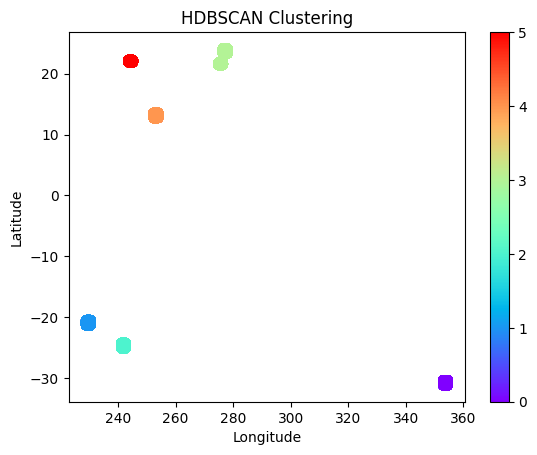

In [4]:
labels = cluster_data(data)
data["LOCATION"] = labels
plot_clusters(data, labels)

On peut voir dans le tableau ci-dessous que les latitude pour les "LOCATION" inférieure à 2 sont négatives, alors que pour les "LOCATION" supérieure à 2 elles sont positives. Cela est utilisé dans notre fichier *format_data.py* afin de créer l'attribut "SOUTHERN_HEMISPHERE".

In [5]:
location_coordinate_relation = data[["LOCATION", "LAT", "LON"]].drop_duplicates().groupby("LOCATION").mean()
location_coordinate_relation

,LAT,LON
LOCATION,,
0,-30.743155,353.750000
1,-20.886571,229.687500
2,-24.641460,241.875000
3,22.998696,276.666667
4,13.142112,253.125000
5,22.059974,244.375000


Le dictionnaire de coordonées est utiliser afin d'obtenir des labels constants entre les différents jeu de données. En effet, le clustering pourrait avoir un résultat différent pour le jeu de données test

In [6]:
# UTILE POUR OBTENIR LES LOCATIONS SUR LE JEU TEST
location_dict = data.groupby('LOCATION').apply(lambda x: list(set((lat, lon) for lat, lon in zip(x['LAT'], x['LON'])))).to_dict()
location_dict

{0: [(-31.09517601, 353.75),
  (-31.09517601, 353.4375),
  (-31.09517601, 353.125),
  (-30.62581486, 353.125),
  (-30.62581486, 353.4375),
  (-30.62581486, 353.75),
  (-30.86049544, 354.0625),
  (-30.86049544, 354.375),
  (-30.39113429, 354.375),
  (-30.39113429, 354.0625),
  (-30.86049544, 353.75),
  (-30.86049544, 353.4375),
  (-30.86049544, 353.125),
  (-30.39113429, 353.125),
  (-30.39113429, 353.4375),
  (-30.39113429, 353.75),
  (-31.09517601, 354.375),
  (-31.09517601, 354.0625),
  (-30.62581486, 354.375),
  (-30.62581486, 354.0625)],
 1: [(-21.00391134, 229.6875),
  (-21.00391134, 229.375),
  (-21.00391134, 229.0625),
  (-20.5345502, 229.6875),
  (-20.5345502, 229.375),
  (-20.5345502, 229.0625),
  (-21.23859192, 230.3125),
  (-21.23859192, 230.0),
  (-20.76923077, 230.0),
  (-20.76923077, 230.3125),
  (-21.23859192, 229.375),
  (-21.23859192, 229.6875),
  (-21.23859192, 229.0625),
  (-20.76923077, 229.375),
  (-20.76923077, 229.6875),
  (-20.76923077, 229.0625),
  (-21.0039113

### Séparation "time" en Année, Mois et Jour

In [7]:
data['YEAR'] = data['time'].apply(lambda x: int(str(x)[:4]))
data['MONTH'] = data['time'].apply(lambda x: int(str(x)[4:6]))
data['DAY'] = data['time'].apply(lambda x: int(str(x)[6:]))
data = data.drop(columns=["time", "LAT", "LON"])

### Transformation de l'échelle de mesure de PRECT de (m/s) à (mm/h)

In [8]:
data["PRECT"] = data["PRECT"] * 3600 * 1000

# Génération de nouvelles données pour les classes sous représentées

In [9]:
data_label0 = data[data['Label'] == 0]
data_label1 = data[data['Label'] == 1]
data_label2 = data[data['Label'] == 2]

In [10]:
from ctgan import CTGAN

# Define the number of synthetic samples needed
synthetic_samples_needed_1 = data_label1.shape[0]
synthetic_samples_needed_2 = data_label2.shape[0]

discrete_columns = [
    'LOCATION',
    'YEAR',
    'MONTH',
    'DAY',
    'Label'
]

In [15]:
# Initialize and train CTGAN for label 1
ctgan_1 = CTGAN(epochs=2000, verbose=True, cuda=True)  # Reduced epochs for time efficiency
ctgan_1.fit(data_label1, discrete_columns)
synthetic_1 = ctgan_1.sample(synthetic_samples_needed_1)

Gen. (0.08) | Discrim. (-0.03): 100%|██████████| 2000/2000 [03:50<00:00,  8.67it/s] 


In [12]:
# Initialize and train CTGAN for label 2
ctgan_2 = CTGAN(epochs=1000, verbose=True, cuda=True)  # Reduced epochs for time efficiency
ctgan_2.fit(data_label2, discrete_columns)
synthetic_2 = ctgan_2.sample(synthetic_samples_needed_2)

Gen. (-0.47) | Discrim. (-0.35): 100%|██████████| 1000/1000 [11:30<00:00,  1.45it/s]


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_28476\1143213042.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_label1[feature], label="Real Data", shade=True, color=colors["Real Data"], ax=axes[i])
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_28476\1143213042.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_1[feature], label="Synthetic Data", shade=True, color=colors["Synthetic Data"], ax=axes[i])
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_28476\1143213042.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_label1[feature], label="Real Data", shade=True, color=colors["Real Da

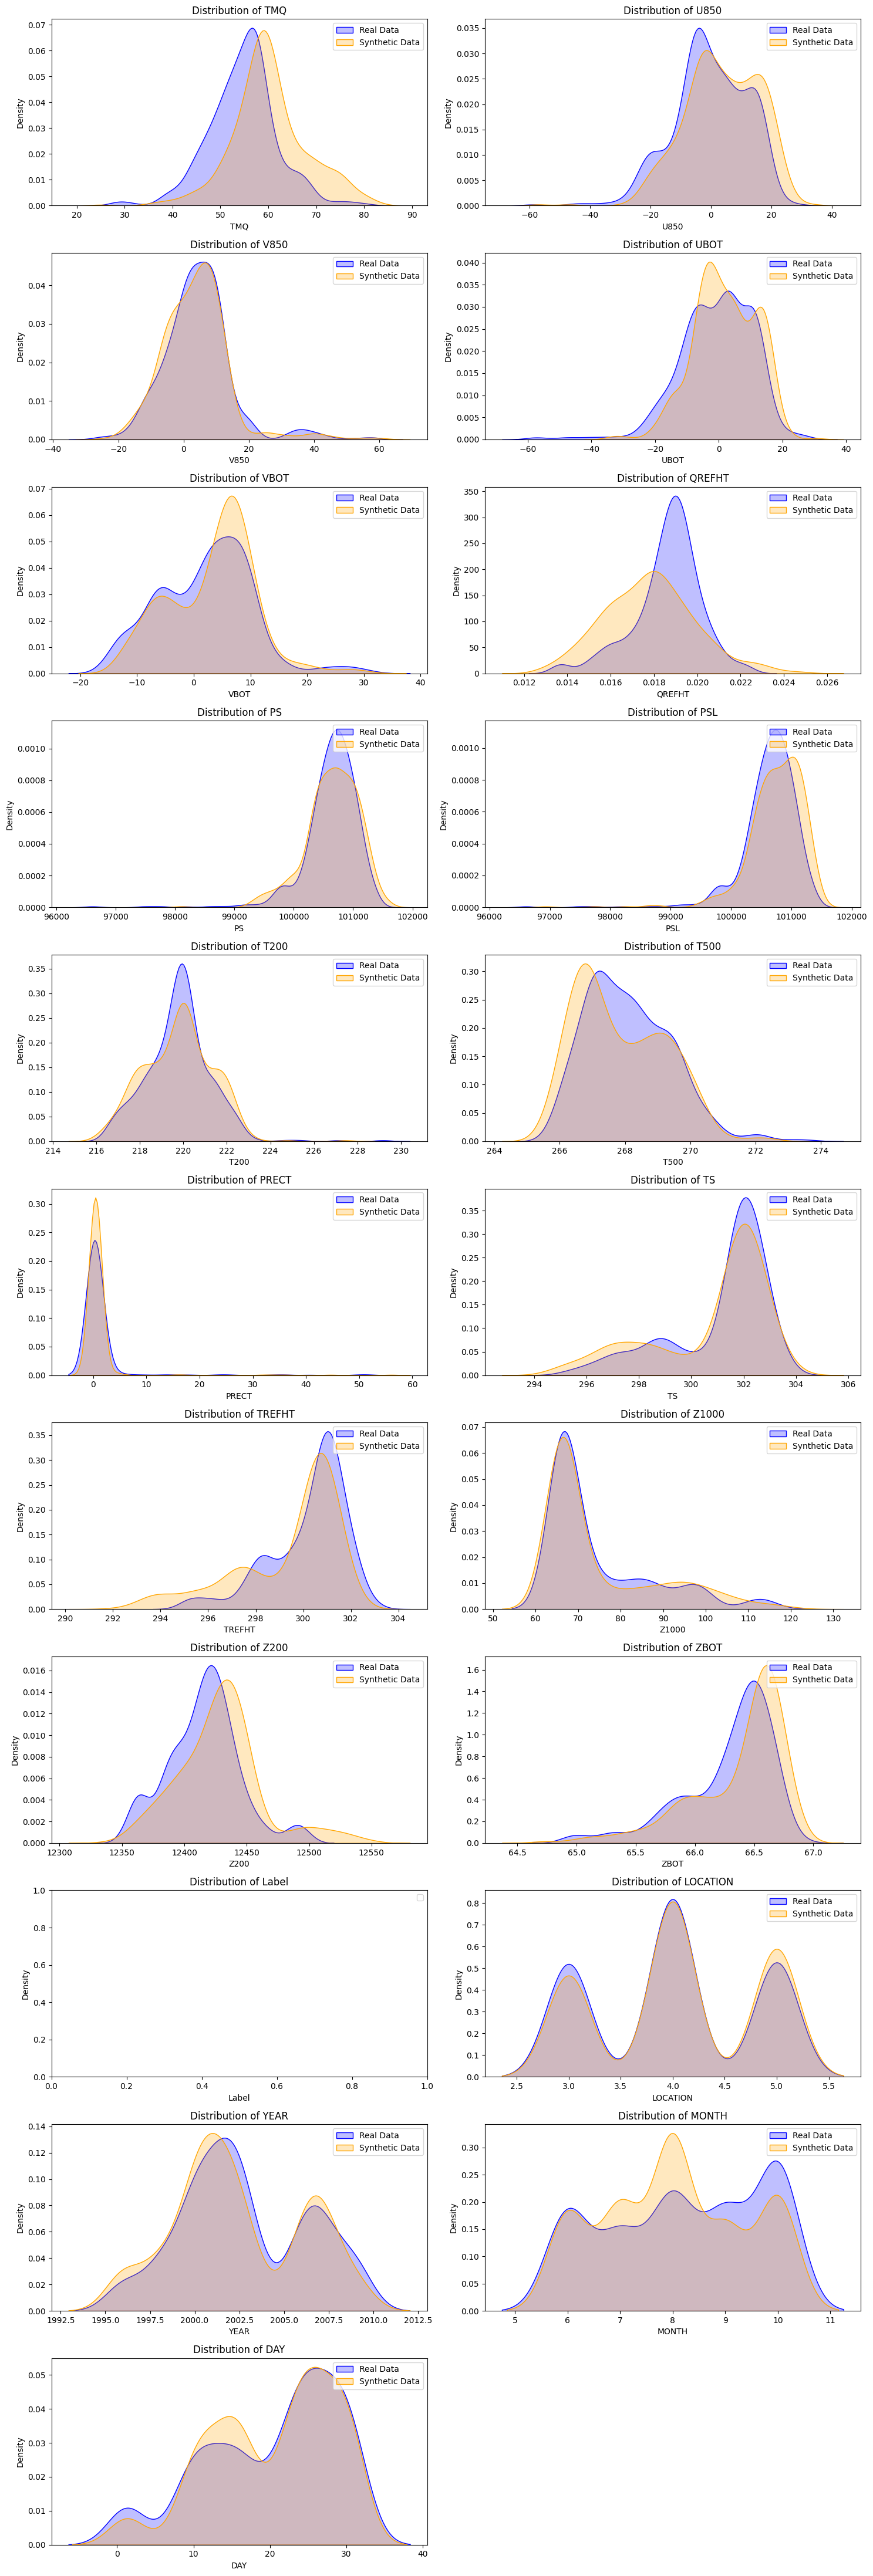

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define colors and labels
colors = {
    "Real Data": 'blue',
    "Synthetic Data": 'orange',
    # Add more categories and colors if needed
}

# Determine the grid layout
n_features = len(data.columns)
n_cols = 2
n_rows = n_features // n_cols + (n_features % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Flatten the axes in case it's a 2D array
axes = axes.flatten()

# Loop through each feature and plot the real and synthetic data KDEs
for i, feature in enumerate(data.columns):
    # Plot KDE for Real Data
    sns.kdeplot(data_label1[feature], label="Real Data", shade=True, color=colors["Real Data"], ax=axes[i])
    
    # Plot KDE for Synthetic Data
    sns.kdeplot(synthetic_1[feature], label="Synthetic Data", shade=True, color=colors["Synthetic Data"], ax=axes[i])
    
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].legend()

# If there are odd numbers of features, remove the extra subplot
if n_features % n_cols:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_28476\3708703652.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_label2[feature], label="Real Data", shade=True, color=colors["Real Data"], ax=axes[i])
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_28476\3708703652.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_2[feature], label="Synthetic Data", shade=True, color=colors["Synthetic Data"], ax=axes[i])
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_28476\3708703652.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_label2[feature], label="Real Data", shade=True, color=colors["Real Da

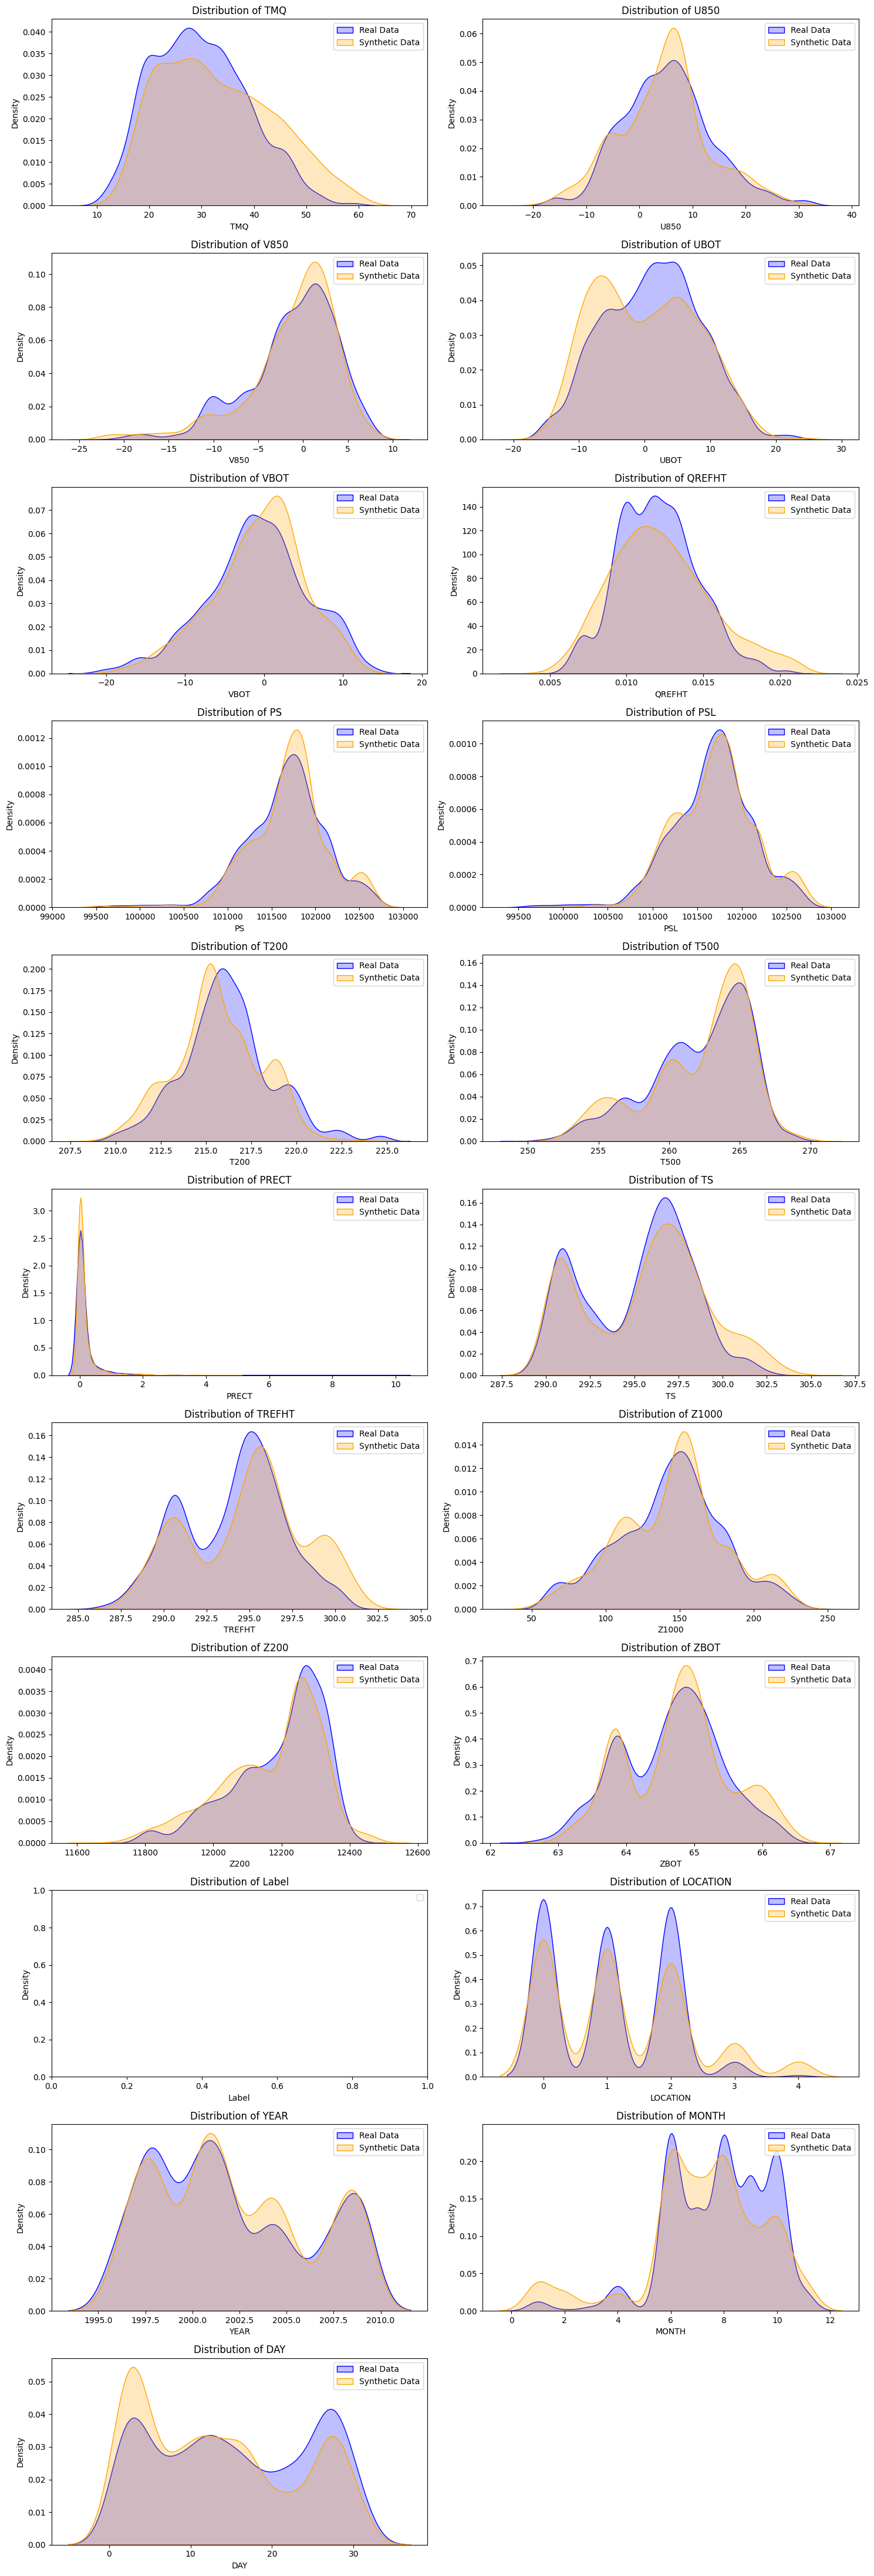

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define colors and labels
colors = {
    "Real Data": 'blue',
    "Synthetic Data": 'orange',
    # Add more categories and colors if needed
}

# Determine the grid layout
n_features = len(data.columns)
n_cols = 2
n_rows = n_features // n_cols + (n_features % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Flatten the axes in case it's a 2D array
axes = axes.flatten()

# Loop through each feature and plot the real and synthetic data KDEs
for i, feature in enumerate(data.columns):
    # Plot KDE for Real Data
    sns.kdeplot(data_label2[feature], label="Real Data", shade=True, color=colors["Real Data"], ax=axes[i])
    
    # Plot KDE for Synthetic Data
    sns.kdeplot(synthetic_2[feature], label="Synthetic Data", shade=True, color=colors["Synthetic Data"], ax=axes[i])
    
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].legend()

# If there are odd numbers of features, remove the extra subplot
if n_features % n_cols:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()


In [30]:
data = pd.concat([data_label0, data_label1, data_label2, synthetic_1, synthetic_2])
data = data.sample(frac=1).reset_index(drop=True)
data

,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,...,TS,TREFHT,Z1000,Z200,ZBOT,Label,LOCATION,YEAR,MONTH,DAY
0,14.278533,-3.173287,1.833835,-7.581432,3.399386,0.006412,103070.359400,103070.359400,214.141617,256.000519,...,289.539368,287.337708,254.114304,12032.929690,62.937675,0,0,2001,10,20
1,44.269070,-3.000973,0.375796,-2.194901,-3.694045,0.017199,101155.218800,101155.218800,219.897949,266.757843,...,301.367340,300.345184,101.970589,12405.989260,66.272552,0,4,2003,10,24
2,29.716904,5.699519,-4.106040,3.079108,-2.678627,0.012480,101841.164100,101841.164100,215.238892,264.979614,...,294.962555,294.458130,158.173508,12271.599610,64.806854,2,2,1998,10,2
3,36.301456,-0.657589,-1.584453,-0.903698,-2.157597,0.017055,101450.968800,101450.968800,217.602081,267.198273,...,303.073181,301.431519,128.287140,12410.470700,66.502525,0,3,2000,8,12
4,29.445889,22.721797,-15.070397,1.895406,-7.071098,0.008437,101568.182752,101137.479833,215.028439,265.348473,...,293.023618,291.561984,105.542662,12037.915827,64.289685,2,0,2005,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21333,16.775038,-4.126678,6.831597,-4.234844,5.019883,0.008671,101950.937500,101950.937500,214.138534,262.182343,...,296.870361,293.301269,166.161133,12180.723630,64.307304,0,2,1997,6,1
21334,44.922436,-9.911572,0.828655,-5.677947,-1.543543,0.019176,101564.820300,101565.976600,215.284180,265.710754,...,302.159241,301.132782,138.384369,12358.180660,66.517250,0,3,2000,6,29
21335,22.976133,8.799085,-1.685878,1.721771,-2.926032,0.009924,102670.101600,102670.101600,210.934235,257.265045,...,291.316833,290.662415,224.763657,11993.750000,63.874550,0,0,2007,7,16
21336,50.522873,0.861236,5.695543,-1.403138,2.239701,0.019056,101072.312500,101072.312500,219.541916,268.598907,...,298.202576,298.570557,94.388489,12466.474610,66.033470,0,5,2004,8,25


# Création de nouveaux attributs

### Ajout d'un attribut "SOUTHERN_HEMISPHERE"

In [31]:
data["SOUTHERN_HEMISPHERE"] = data["LOCATION"] <= 2

### Changement d'échelle pour PRECT

In [ ]:
data["PRECT"] = data["PRECT"] * 3600 * 1000

### Ajout de la magnitude et de la direction des vents

In [32]:
# Magnitude
data["WIND850_MAGNITUDE"] = np.sqrt(data["U850"]**2 + data["V850"]**2)
data["WINDBOT_MAGNITUDE"] = np.sqrt(data["UBOT"]**2 + data["VBOT"]**2)

# Directions
data['WIND850_DIRECTION'] = np.arctan2(data['V850'], data['U850'])
data['WINDBOT_DIRECTION'] = np.arctan2(data['VBOT'], data['UBOT'])

### Ajout de l'interaction entre les vitesses de vents

In [33]:
data['WIND850_INTERACTION'] = data['U850'] * data['V850']
data['WINDBOT_INTERACTION'] = data['UBOT'] * data['VBOT']

### Ajout de l'interaction entre la pression et les vents

In [39]:
data['PS_WIND850_INTERACTION'] = data['PS'] * data['WIND850_MAGNITUDE']
data['PS_WINDBOT_INTERACTION'] = data['PS'] * data['WINDBOT_MAGNITUDE']

### Ajout différences de températures et de pressions

In [34]:
data['PRESSURE_DIFFERENCE'] = data['PS'] - data['PSL']
data['TEMP_DIFFERENCE'] = data['T200'] - data['T500']

### Cisaillement vertical du vent

In [35]:
data['WIND_SHEAR'] = data['WINDBOT_MAGNITUDE'] - data['WIND850_MAGNITUDE']

### Diférence de géopotentiel

In [36]:
data['GEOPOTENTIAL_DIFF'] = data['Z200'] - data['Z1000']

### Ajout de la saison

In [38]:
data['SEASON'] = data['MONTH'].apply(lambda x: 'Winter' if x in [12, 1, 2] else ('Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else 'Fall')))

# Sauvegarde

In [40]:
data.to_csv("./data/GAN_train.csv")